Name: Andres Figueroa

Email: andresfigueroa@brandeis.edu

Description: The goal of this project is to build a model that predicts whether a pokemon is Legendary or not based on
its stats and other features.


In [59]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

---
#### Building Our DataFrame

In [43]:
df = pd.read_csv('pokemon.csv')

print(df.columns)
print(df.head())

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')
                     abilities  against_bug  against_dark  against_dragon  \
0  ['Overgrow', 'Chlorophyll']          1.0           1.0             1.0   
1  ['Overgrow', 'Chlorophyll']          1.0           1.0             1.0   
2  ['Overgrow', 'Chlorophyll']          1.0         

In [44]:
df.dtypes

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

---

#### Defining Our ML Problem


##### Dataset Explanation
The dataset I chose contains information on all 802 Pokémon from seven generations. It includes statistics such as base stats, types, abilities, height, weight, egg steps, capture rate, experience growth, and more.


##### What We Are Predicting (Label)
The label I will be predicting is 'is_legendary'. This is a binary feature as there are two classifications whether a Pokémon is legendary or not.


##### Problem Type
This is a supervised learning problem, because we are training a model using labeled data where the target (is_legendary) is known.

It is a classification problem, a binary classification problem, since the model is predicting one of two things: legendary or not legendary.



##### Importance
Though this project is a personal work (I liked pokemon growing up), this project can be used for companies or developers working on games, to enrich user interaction, balance game dynamics, and target content creation around Pokémon classification.

---

#### Understanding Our Data

##### Missing Data

In [45]:
df.isnull().sum()[df.isnull().sum() > 0]

height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64

##### Note:
While 'height_m' and 'weight_kg' are numerical features, I will probably drop the following features because pokemon, even legendary, can range from big to small and I believe that height and weight have no bearing on whether a pokemon is legendary or not. I believe the same with types, a legendary pokemon can have almost any typing, so I will probably drop type1 and type2. 'percentage_male' is interesting because I remembered that there are genderless pokemon which explains the missing values. Still I believe gender doesn't play a role in determining whether a pokemon is legendary or not. As I remove these features, I am simplifying the dataset and avoiding unnecessary noise.

#### Visualizing Potential Outliers

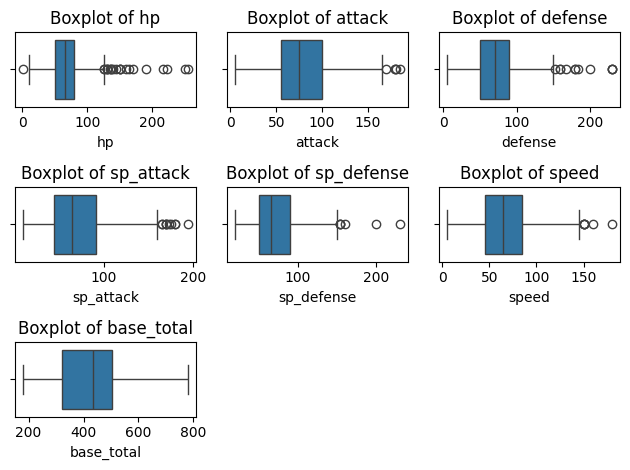

In [46]:
outlier_features = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'base_total']

for i, feature in enumerate(outlier_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = df[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

##### Note:
The following boxplots visualize distributions for key  features ('hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', and 'base_total'). It is clear from the plots that there are a number of outliers on the higher end of each distribution.

Though there are clearly outliers I am hesitant to remove them because some non-legendary Pokémon, referred to by the community as pseudo-legendary, have very high base stats, typically totaling 600. These Pokémon (e.g., Dragonite, Garchomp, Hydreigon) evolve from earlier forms and are difficult to raise, but are not classified as legendary.

Keeping the outliers may help the model tell the difference between powerful non-legendaries and actual legendaries based on more complex patterns.

#### Getting a Better Understanding of is_legendary (Our Label)

In [47]:
df["is_legendary"]

0      0
1      0
2      0
3      0
4      0
      ..
796    1
797    1
798    1
799    1
800    1
Name: is_legendary, Length: 801, dtype: int64

##### Note:
This is great. The label is already encoded and can be used by the model.

In [48]:
df["is_legendary"].value_counts()

is_legendary
0    731
1     70
Name: count, dtype: int64

##### Note:
There's a significant class imbalances between legendary and non-legendary pokemon. This is important to note because models will be bias and lean towards predicting the majority class (non-legendary). We can use resampling techniques (like SMOTE), or use class weights.

#### Feature Engineering

In [49]:
#print(df.dtypes)
df['capture_rate'] = pd.to_numeric(df['capture_rate'], errors='coerce')
df['capture_rate'].dtype


dtype('float64')

##### Note:
I saw that 'capture_rate' wasn't a numerical value, but rather a string. So, I converted it to a numerical value.

#### Dropping Features

In [50]:
to_drop = ['abilities', 'name', 'percentage_male', 'pokedex_number', 'generation', 'type1', 'type2', 'japanese_name', 'base_egg_steps', 'classfication', 'height_m', 'weight_kg'] # Some features that I think are irrelevant to the problem
df = df.drop(columns = to_drop, errors = 'ignore')

to_keep = []
for col in df.columns: # Because I don't want to copy and paste all the weaknesses
    if 'against' not in col: # I want to get rid of all features with 'against' because their weakness tell us nothing about whether they are legendary or not
        to_keep.append(col)

df = df[to_keep]
#print(df.dtypes)
df = df.dropna()

df.columns

Index(['attack', 'base_happiness', 'base_total', 'capture_rate', 'defense',
       'experience_growth', 'hp', 'sp_attack', 'sp_defense', 'speed',
       'is_legendary'],
      dtype='object')

##### Note:
I am dropping 'abilities' because legendary and non-legendary pokemon don't have exclusive abilities. I am also dropping 'name', 'pokedex_number', 'generation', 'japanese_name', and 'classfication' because these are identifiers that tell us nothing on whether a pokemon is legendary or not.

I dropped the all columns with 'against' because their weaknesses tell us nothing about whether they are legendary or not.

I decided to drop the feature 'base_egg_steps' because legendary pokemon don't hatch from eggs and this will essentially cause a data leakage, giving the model the answers rather than learning anything.

'capture_rate' was of the object type, specifically a string. So, I converted it to a numerical value

---

##### Note:
Since this is a binary classification problem, I think I will use:
- Logistic Regression
- Random Forest Classifier
- XGBoost

In addition, I will balance the model data set using SMOTE to oversample the minority class (legendary pokemon) in the training set as there is a significant imbalance between legendary and non-legendary pokemon.



Evaluation Metrics I will use to evaluate the models performance:
- Accuracy: How often the model correctly predicts the outcome

- F1 Score: The balance between Precision and Recall

- Precision: Shows us how many predicted legendaries were actually legendary

- Recall: Shows us how many actual legendaries were correctly identified.

- ROC-AUC: Measures how well the model separates classes.

- Confusion Matrix: Helps identify false positives and false negatives.
---

#### Defining The Project Plan

The features I chose to keep include numerical stats such as 'attack', 'base_happiness', 'base_total', 'capture_rate', 'defense', 'experience_growth', 'hp', 'sp_attack', 'sp_defense', and 'speed'. I believe that the stats of a pokemon are the most directly related to a Pokémon’s strength and may influence whether it is classified as legendary. I dropped features such as 'height_m', 'weight_kg', 'type1', and 'type2' because legendary Pokémon can vary widely in size and typing. Identifiers like 'name' and 'japanese_name' were also removed as they provide no value.

The models I will explore are Logistic Regression as a baseline, and Random Forest and XGBoost as they're capable of binary classification and capable of modeling complex interactions.


I will focus on accuracy, F1 score, precision, recall, confusion matrix, and ROC-AUC as evaluation metrics rather than plain accuracy. Hyperparameter tuning will be conducted using GridSearchCV or RandomizedSearchCV.

---

##### Implementing Our Project Plan

In [90]:
y = df['is_legendary']
X = df.drop(columns = 'is_legendary')

##### Splitting the Data

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234, stratify = y)

##### Feature Scaling

In [92]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

##### Addressing Class Imbalance with SMOTE

In [93]:
smote = SMOTE(random_state = 1234)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

##### Training a Logistic Regression Model

In [94]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_smote, y_train_smote)
y_pred = lr.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       146
           1       0.72      0.93      0.81        14

    accuracy                           0.96       160
   macro avg       0.86      0.95      0.90       160
weighted avg       0.97      0.96      0.96       160

ROC AUC: 0.9471624266144814


#### Training a Random Forest Model

In [95]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rf))
print("ROC AUC (RF):", roc_auc_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       146
           1       1.00      0.93      0.96        14

    accuracy                           0.99       160
   macro avg       1.00      0.96      0.98       160
weighted avg       0.99      0.99      0.99       160

ROC AUC (RF): 0.9642857142857143


#### Training a XGBoost Model

In [96]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

xgb_preds = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_proba))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       146
           1       1.00      0.93      0.96        14

    accuracy                           0.99       160
   macro avg       1.00      0.96      0.98       160
weighted avg       0.99      0.99      0.99       160

ROC AUC Score: 1.0


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [16:14:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### ENDS HERE